In [81]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col, year, to_date, pandas_udf, StringType, size, split, desc
import os

from embedders.my_sentence_transformer import MySentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from scipy.cluster.hierarchy import inconsistent, cophenet, fcluster

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import gensim

In [82]:
def hierarchical_cluster(
        embeddings, 
        k, 
        metric="cosine", 
        linkage="average"
    ):
    """
    embeddings: (n_samples, dim) normalized embeddings
    k: number of clusters to extract
    """

    # Agglomerative Clustering
    model = AgglomerativeClustering(
        n_clusters=k,
        metric=metric,
        linkage=linkage
    )
    
    labels = model.fit_predict(embeddings)
    return labels

In [83]:
def compute_nmf_coherence(texts, k, n_top_words=10):
    """
    Compute UMass coherence for NMF topics at a given K.
    texts should be a list of strings.
    """
    if len(texts) < 10:
        return np.nan

    # Tokenize for gensim
    processed = [t.lower().split() for t in texts]

    dictionary = Dictionary(processed)

    # TF-IDF for NMF
    tfidf_vec = TfidfVectorizer(
        stop_words="english",
        max_features=5000,
        min_df=3,
        max_df=0.95
    )
    tfidf = tfidf_vec.fit_transform(texts)
    feature_names = tfidf_vec.get_feature_names_out()

    # NMF model
    nmf = NMF(
        n_components=k,
        init="nndsvd",
        random_state=42,
        max_iter=500
    )
    W = nmf.fit_transform(tfidf)
    H = nmf.components_

    # Extract top words per topic
    topics = []
    for t in range(k):
        top_indices = H[t].argsort()[-n_top_words:][::-1]
        topics.append([feature_names[i] for i in top_indices])

    # Build Gensim CoherenceModel
    cm = CoherenceModel(
        topics=topics,
        texts=processed,
        dictionary=dictionary,
        coherence='u_mass'
    )

    return cm.get_coherence()


In [84]:
def evaluate_k_hierarchical(embeddings, texts, k_values):
    results = []

    # Precompute distance matrix once
    dist_matrix = cosine_distances(embeddings)

    for k in k_values:
        labels = hierarchical_cluster(embeddings, k)

        # Silhouette using cosine distance
        sil = silhouette_score(dist_matrix, labels, metric="precomputed")

        # Intra-cluster cosine similarity
        intra = []
        for c in range(k):
            cluster_embs = embeddings[labels == c]
            if len(cluster_embs) > 1:
                sim = cosine_similarity(cluster_embs)
                intra.append(np.mean(sim[np.triu_indices_from(sim, k=1)]))
        avg_intra = np.mean(intra)

        # Inter-centroid cosine similarity
        centroids = np.vstack([
            embeddings[labels == c].mean(axis=0)
            for c in range(k)
        ])
        centroid_cos = cosine_similarity(centroids)
        mask = ~np.eye(k, dtype=bool)
        inter = np.mean(centroid_cos[mask])

        # 🌟 NEW: NMF lexical coherence for this K
        coherence = compute_nmf_coherence(texts, k)

        results.append({
            "k": k,
            "silhouette": sil,
            "avg_intra_cosine": avg_intra,
            "inter_centroid_cosine": inter,
            "nmf_coherence": coherence     # NEW METRIC
        })

    return results

In [85]:
def plot_hierarchical_results(results):
    df = pd.DataFrame(results)

    fig, ax = plt.subplots(1, 4, figsize=(22, 4))

    ax[0].plot(df["k"], df["silhouette"], marker="o")
    ax[0].set_title("Silhouette (Cosine)")
    ax[0].set_xlabel("k")

    ax[1].plot(df["k"], df["avg_intra_cosine"], marker="o")
    ax[1].set_title("Avg Intra-Cluster Cosine")
    ax[1].set_xlabel("k")

    ax[2].plot(df["k"], df["inter_centroid_cosine"], marker="o")
    ax[2].set_title("Inter-Centroid Cosine (Lower=Better)")
    ax[2].set_xlabel("k")

    # 🌟 NEW PLOT
    ax[3].plot(df["k"], df["nmf_coherence"], marker="o")
    ax[3].set_title("NMF Topic Coherence (Higher=Better)")
    ax[3].set_xlabel("k")

    plt.show()

In [86]:
def plot_dendrogram(embeddings, method="average", metric="cosine", truncate=30):
    """
    embeddings: normalized embedding matrix (n_samples × dim)
    method: linkage method ('average' recommended for cosine)
    metric: distance metric ('cosine' recommended)
    truncate: how many leaf nodes to show (prevents huge trees)
    """

    # SciPy linkage needs a condensed distance matrix or raw vectors.
    # For cosine distance + average linkage, we can pass raw embeddings.
    Z = linkage(embeddings, method=method, metric=metric)

    plt.figure(figsize=(14, 6))
    dendrogram(
        Z,
        truncate_mode="lastp",   # show only top clusters
        p=truncate,             # number of leaf nodes to show
        leaf_rotation=90.,
        leaf_font_size=10.,
        show_contracted=True
    )
    plt.title(f"Hierarchical Clustering Dendrogram ({method}, {metric})")
    plt.xlabel("Cluster size / merged points")
    plt.ylabel("Cosine Distance")
    plt.show()

    return Z

In [87]:
def compare_kmeans_vs_hierarchical(embeddings, k):
    # KMeans (on normalized embeddings)
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_labels = km.fit_predict(embeddings)

    # Hierarchical
    hier_labels = hierarchical_cluster(embeddings, k)

    # Cosine silhouette
    dist_matrix = cosine_distances(embeddings)
    km_sil = silhouette_score(dist_matrix, km_labels, metric="precomputed")
    hier_sil = silhouette_score(dist_matrix, hier_labels, metric="precomputed")

    print(f"KMeans silhouette:       {km_sil:.4f}")
    print(f"Hierarchical silhouette: {hier_sil:.4f}")


In [88]:
nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(texts, limit=30):
    phrases = []
    for t in texts:
        doc = nlp(t)
        phrases.extend([chunk.text for chunk in doc.noun_chunks])
    return phrases[:limit]


def extract_theme_info(texts, n_top_words=10):
    """
    Final theme extractor:
      - NMF top theme words
      - noun phrases
      - example reviews
    """

    # If cluster is too small, return minimally
    if len(texts) < 4:
        return {
            "nmf_terms": [],
            "noun_phrases": extract_noun_phrases(texts),
            "examples": texts[:3]
        }

    # ----------------------------------------------------
    # 1. TF-IDF → required as input for NMF
    # ----------------------------------------------------
    tfidf_vec = TfidfVectorizer(
        stop_words="english",
        min_df=1,
        max_df=0.95,
        max_features=3000
    )
    tfidf_matrix = tfidf_vec.fit_transform(texts)
    feature_names = tfidf_vec.get_feature_names_out()

    # ----------------------------------------------------
    # 2. NMF (1 topic = clean lexical theme)
    # ----------------------------------------------------
    nmf = NMF(
        n_components=1,
        init="nndsvd",
        random_state=42,
        max_iter=500
    )
    nmf.fit(tfidf_matrix)
    H = nmf.components_[0]

    top_indices = H.argsort()[-n_top_words:][::-1]
    nmf_terms = [feature_names[i] for i in top_indices]

    # ----------------------------------------------------
    # 3. Noun phrases
    # ----------------------------------------------------
    noun_phrases = extract_noun_phrases(texts)

    # ----------------------------------------------------
    # 4. Examples
    # ----------------------------------------------------
    examples = texts[:3]

    return {
        "nmf_terms": nmf_terms,
        "noun_phrases": noun_phrases,
        "examples": examples
    }

In [89]:
def make_theme_card(cluster_id, nmf_terms, noun_phrases, examples, sentiment="auto"):
    """
    Generate a full theme card using NMF terms, noun phrases,
    examples, and optional sentiment analysis by the LLM.
    """

    prompt = f"""
    You are analyzing a cluster of Yelp reviews and generating a business-ready theme summary.
    
    ### Cluster ID
    {cluster_id}
    
    ### Core Theme Words (NMF)
    These words represent the primary latent theme of this cluster:
    {nmf_terms}
    
    ### Noun Phrases (Context)
    Use these only as context clues, not as theme names:
    {noun_phrases[:20]}
    
    ### Example Reviews (Evidence)
    Use these to ground your interpretation:
    ---
    {examples[0] if len(examples) > 0 else ""}
    ---
    {examples[1] if len(examples) > 1 else ""}
    ---
    {examples[2] if len(examples) > 2 else ""}
    
    ### Sentiment Handling
    Sentiment mode: {sentiment}.
    - If sentiment="auto", infer overall sentiment of this theme from the reviews.
    - If sentiment="positive" / "negative" / "mixed", incorporate that directly.
    - Sentiment should influence tone of Likes/Dislikes, but NOT the theme name.
    
    ### OUTPUT FORMAT (strict)
    Provide the following sections, cleanly formatted:
    
    **Theme Title:** (short, human-readable)
    **Summary:** (2–3 sentences)
    **Likes:** (bullet list)
    **Dislikes:** (bullet list)
    **Business Importance:** (why the business should care)
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        max_completion_tokens=300
    )

    return response.choices[0].message.content

In [90]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

In [91]:
reviews_df = spark.read.parquet("yelp_reviews.parquet")

In [20]:
top_business_id = '_ab50qdWOk0DdB6XOrBitw'

In [21]:
# Retrieve reviews for top business
top_business_reviews = reviews_df.filter(col('business_id') == top_business_id)

In [22]:
top_business_reviews.count()

7673

In [23]:
top_business_reviews_df = top_business_reviews.toPandas()

In [24]:
top_business_reviews_df = top_business_reviews_df.drop(['user_id', 'useful', 'funny', 'cool'], axis=1)

In [25]:
my_mpnet_transformer = MySentenceTransformer(model_name='paraphrase-MiniLM-L3-v2')

In [26]:
embs = my_mpnet_transformer.transform_sentences(top_business_reviews_df.text)

In [29]:
# 1. Normalize embeddings
emb = embs / np.linalg.norm(embs, axis=1, keepdims=True)

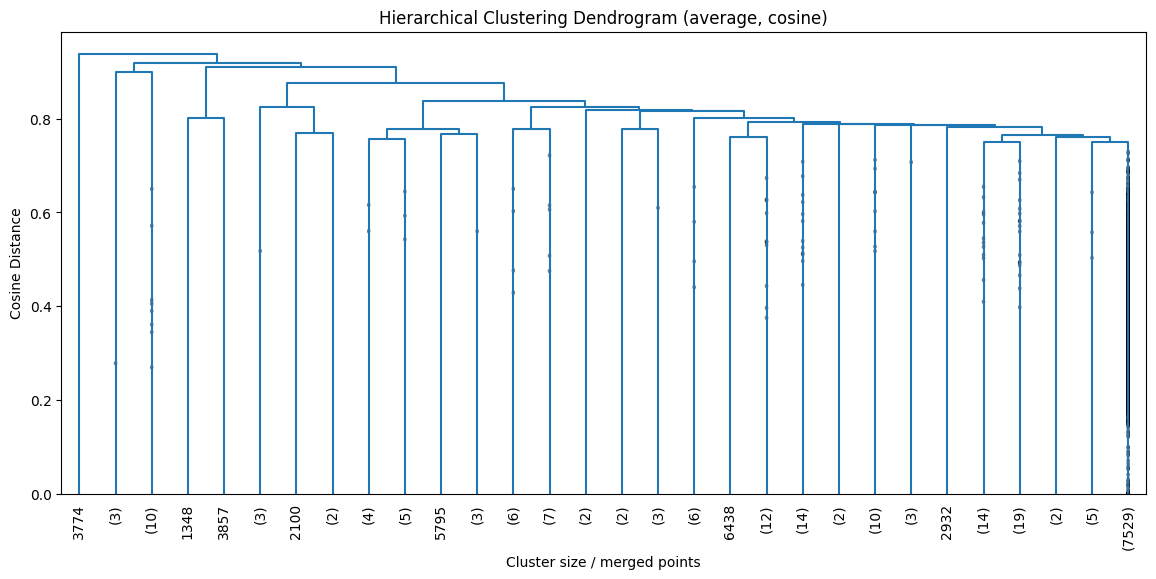

In [46]:
Z = plot_dendrogram(emb, method="average", metric="cosine", truncate=30)

In [52]:
def plot_dendrogram_with_cuts(Z, K_list=[3, 4], truncate=20):
    """
    Z: linkage matrix
    K_list: list of K values where horizontal cut lines will be drawn
    truncate: number of leaves to show (use 20–30 for readability)
    """

    plt.figure(figsize=(15, 6))

    dendrogram(
        Z,
        truncate_mode="lastp",
        p=truncate,
        color_threshold=0,
        leaf_rotation=90,
        leaf_font_size=10,
        show_contracted=True
    )

    # --- Compute heights for each K ---
    
    max_dist = Z[:, 2].max()

    for K in K_list:
        # scipy fcluster produces clusters for a given distance threshold
        # We reverse-find the distance threshold that yields K clusters
        # This method gets the height just before merge into <K clusters
        # Sort merge heights descending
        merge_heights = sorted(Z[:, 2], reverse=True)

        # the (K-1)-th largest merge height is the cut height
        # because K clusters → K-1 merges above cut level
        cut_height = merge_heights[K - 1]

        # plot horizontal line
        plt.axhline(y=cut_height, color="red", linestyle="--", linewidth=1.5)
        plt.text(
            0, cut_height + 0.01,
            f"K = {K} (cut @ {cut_height:.3f})",
            color="red",
            fontsize=12,
            va="bottom"
        )

    plt.title("Dendrogram with Horizontal Cuts for K = 3 and K = 4")
    plt.ylabel("Cosine Distance")
    plt.xlabel("Merged Clusters (truncated)")
    plt.show()

In [53]:
Z = linkage(embs, method="average", metric="cosine")

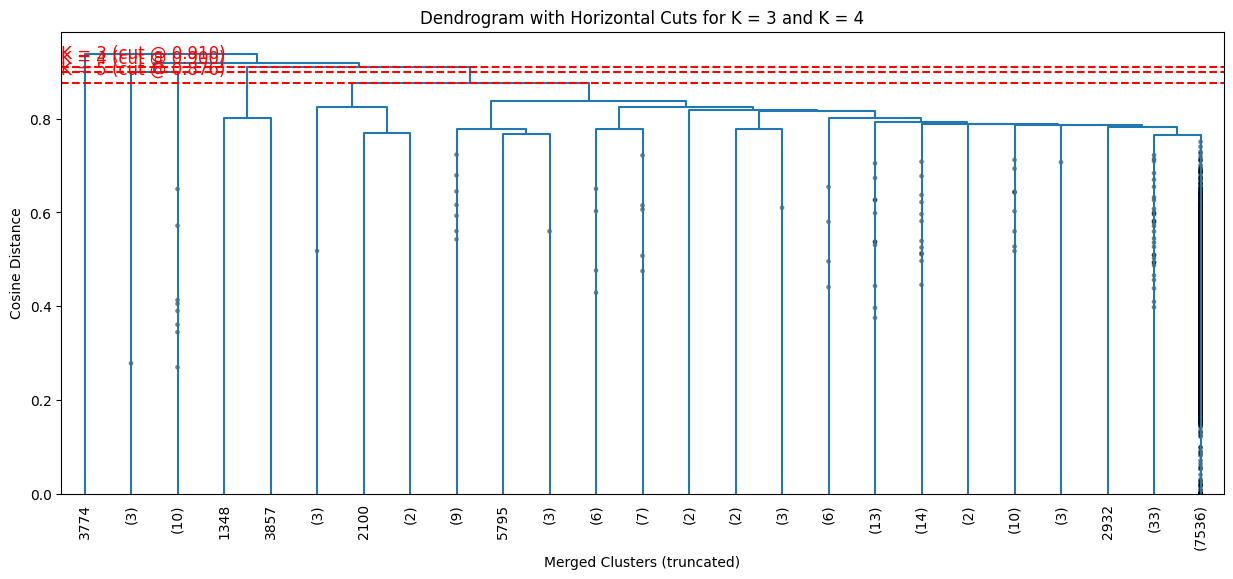

In [54]:
plot_dendrogram_with_cuts(Z, K_list=[3, 4, 5], truncate=25)

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


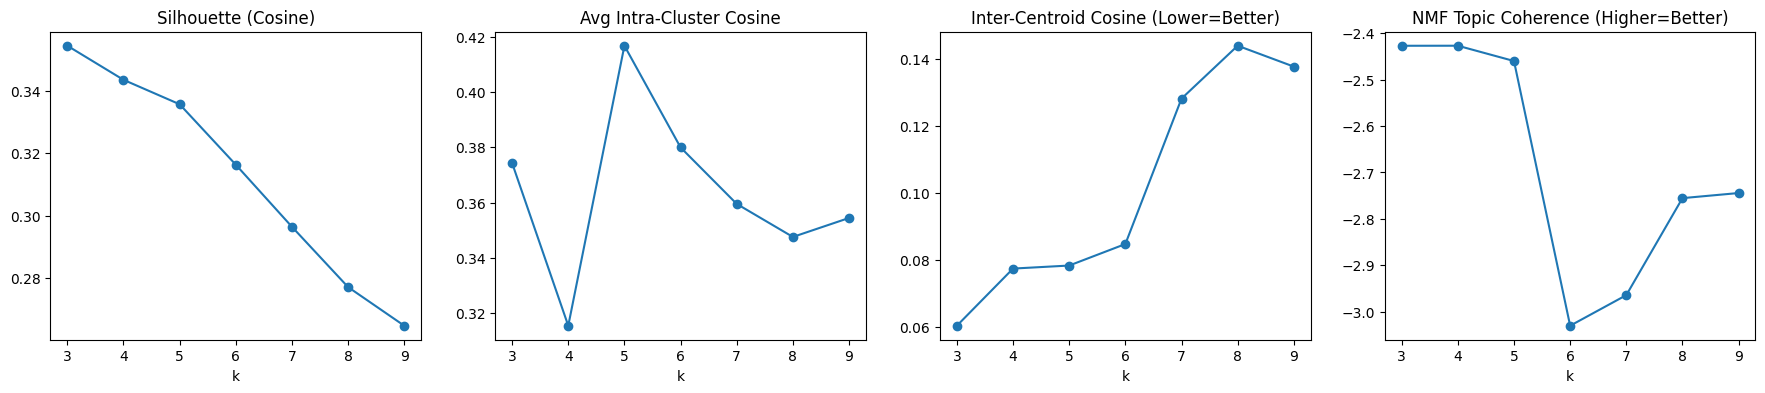

In [94]:
# 2. Evaluate K
results = evaluate_k_hierarchical(emb, top_business_reviews_df["text"].tolist(), k_values=range(3,10))
plot_hierarchical_results(results)

In [65]:
# 3. Pick best K
best_k = min(results, key=lambda r: r["inter_centroid_cosine"])["k"]
best_k = 4

In [66]:
# 4. Cluster
labels = hierarchical_cluster(emb, best_k)
top_business_reviews_df["cluster_id"] = labels

In [67]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [68]:
from openai import OpenAI
client = OpenAI()

In [76]:
import time

# 5. Extract themes
for c in range(best_k):
    # get cluster reviews
    texts_c = top_business_reviews_df[top_business_reviews_df.cluster_id == c].text.tolist()

    # extract info
    # top_terms, noun_phrases, examples = extract_theme_info(texts_c)
    info = extract_theme_info(texts_c)

    nmf_terms     = info["nmf_terms"]
    noun_phrases  = info["noun_phrases"]
    examples      = info["examples"]
    
    # generate safe theme card
    print(f"\n===== THEME CARD FOR CLUSTER {c} =====")
    # print(make_theme_card(c, top_terms, noun_phrases, examples, sentiment="auto"))


    print(make_theme_card(c, nmf_terms, noun_phrases, examples))


    # sleep to avoid TPM burst
    time.sleep(1)


===== THEME CARD FOR CLUSTER 0 =====
**Theme Title:** Dining Experience and Service Quality

**Summary:** This cluster reflects a generally positive dining experience, highlighting the enjoyable ambiance and exceptional service. Customers appreciated the delicious food, particularly the chargrilled oysters and other New Orleans specialties, although there were some complaints about the noise levels and certain food preparations.

**Likes:**
- Overall enjoyable atmosphere and good service.
- Delicious chargrilled oysters and New Orleans Medley.
- Fair pricing in relation to the food quality.
- Efficient seating for small groups.

**Dislikes:**
- Noise levels make conversation difficult.
- Some dishes were criticized for being overly processed or served in an American style.

**Business Importance:** Understanding customer feedback on dining experiences and service quality helps the business enhance its offerings and address issues like noise management. This insight can guide improveme